In [89]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install pyg-lib -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [90]:
!python -c "import torch; print('Torch version:', torch.__version__)"
!pip list | grep torch
!pip list | grep torch-geometric

Torch version: 2.5.1+cu121
torch                              2.5.1+cu121
torch-cluster                      1.6.3+pt20cu118
torch-geometric                    2.6.1
torch-scatter                      2.1.2+pt20cu118
torch-sparse                       0.6.18+pt20cu118
torch-spline-conv                  1.2.2+pt20cu118
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121
torch-geometric                    2.6.1


In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx, from_networkx

import networkx as nx
import matplotlib.pyplot as plt
import time


Data(x=[100, 16], edge_index=[2, 484], y=[100])


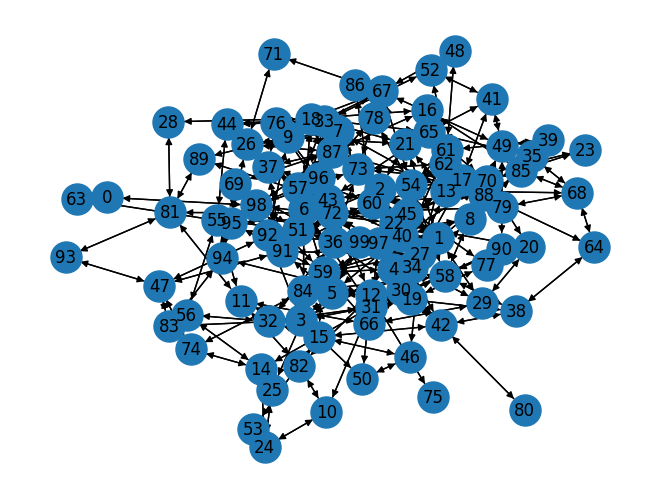

In [96]:
import torch
from torch.nn import CrossEntropyLoss
from torch_geometric.data import Data

# Define the criterion
criterion = CrossEntropyLoss()

# Define MPNN hyperparameters
hidden_channels = 32  # Number of hidden units
num_layers = 3        # Number of layers in the MPNN
epochs = 20           # Number of training epochs
lr = 0.01             # Learning rate

# Placeholder for results
er_results = []

def generate_er_graph_with_labels(num_nodes, edge_prob, num_classes=3):
    g = nx.erdos_renyi_graph(num_nodes, edge_prob)
    x = torch.randn((num_nodes, 16))  # Random node features
    edge_index = torch.tensor(list(g.edges), dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make bidirectional
    y = torch.randint(0, num_classes, (num_nodes,))  # Random labels
    return Data(x=x, edge_index=edge_index, y=y)


# Example: Generate a sparse graph and visualize it
graph = generate_er_graph_with_labels(num_nodes=100, edge_prob=0.05)
print(graph)
nx.draw(to_networkx(graph), with_labels=True, node_size=500)
plt.show()


In [97]:
from torch_geometric.nn import GCNConv

class SkipMPNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(SkipMPNN, self).__init__()
        self.layers = nn.ModuleList()
        self.skip_connections = nn.ModuleList()

        # Create layers
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
            self.skip_connections.append(nn.Linear(hidden_channels, hidden_channels))
        self.out = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        hidden = x
        for i, layer in enumerate(self.layers):
            updated = layer(hidden, edge_index)
            if i > 0:
                updated = updated + self.skip_connections[i - 1](hidden)  # Skip connection
            hidden = F.relu(updated)  # Apply non-linearity
        return self.out(hidden)



In [98]:
def train_model(model, data, optimizer, criterion, epochs=100):
    """
    Train the model on the given data.
    Args:
        model (nn.Module): The MPNN model.
        data (Data): PyTorch Geometric Data object.
        optimizer: Optimizer.
        criterion: Loss function.
        epochs (int): Number of training epochs.
    Returns:
        list: Training loss per epoch.
    """
    model.train()
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)  # Node feature reconstruction as a task
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
    return losses


In [104]:
from sklearn.metrics import accuracy_score
import time

# Ensure the results list is initialized
er_results = []

# Split graph into training and validation sets
def split_graph(graph, split_ratio=0.8):
    num_nodes = graph.x.size(0)
    train_mask = torch.rand(num_nodes) < split_ratio
    val_mask = ~train_mask
    return train_mask, val_mask

# Run experiments for different edge probabilities
for p in edge_probs:
    print(f"Running experiment with edge probability {p}...")
    graph = generate_er_graph_with_labels(num_nodes, p, num_classes=num_classes)
    train_mask, val_mask = split_graph(graph)

    model = SkipMPNN(
        in_channels=graph.x.size(1),
        hidden_channels=hidden_channels,
        out_channels=num_classes,  # Align with number of classes
        num_layers=num_layers
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    total_epoch_time = 0
    losses = []
    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()
        optimizer.zero_grad()
        out = model(graph.x, graph.edge_index)  # Forward pass
        loss = criterion(out[train_mask], graph.y[train_mask])  # Use train_mask
        loss.backward()
        optimizer.step()

        epoch_time = time.time() - epoch_start
        total_epoch_time += epoch_time

        losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Time: {epoch_time:.4f}s")

    # Compute average epoch time
    avg_epoch_time = total_epoch_time / epochs

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_out = model(graph.x, graph.edge_index)  # Forward pass
        val_preds = val_out[val_mask].argmax(dim=1)  # Predicted classes
        val_labels = graph.y[val_mask]  # True labels
        val_accuracy = accuracy_score(val_labels.cpu(), val_preds.cpu())  # Validation accuracy

    # Save results
    er_results.append({
        "edge_prob": p,
        "time": total_epoch_time,
        "avg_epoch_time": avg_epoch_time,
        "final_loss": losses[-1],
        "val_accuracy": val_accuracy
    })

# Print results
for result in er_results:
    print(f"Edge Probability {result['edge_prob']}: Time = {result['time']:.2f}s, "
          f"Average Epoch Time = {result['avg_epoch_time']:.4f}s, "
          f"Final Loss = {result['final_loss']:.4f}, Validation Accuracy = {result['val_accuracy']:.4f}")


Running experiment with edge probability 0.01...
Epoch 1/20, Loss: 1.1068, Time: 0.0058s
Epoch 2/20, Loss: 1.0517, Time: 0.0046s
Epoch 3/20, Loss: 1.0081, Time: 0.0044s
Epoch 4/20, Loss: 0.9571, Time: 0.0043s
Epoch 5/20, Loss: 0.8962, Time: 0.0043s
Epoch 6/20, Loss: 0.8332, Time: 0.0044s
Epoch 7/20, Loss: 0.7701, Time: 0.0045s
Epoch 8/20, Loss: 0.7079, Time: 0.0044s
Epoch 9/20, Loss: 0.6424, Time: 0.0044s
Epoch 10/20, Loss: 0.5729, Time: 0.0043s
Epoch 11/20, Loss: 0.5051, Time: 0.0049s
Epoch 12/20, Loss: 0.4408, Time: 0.0048s
Epoch 13/20, Loss: 0.3824, Time: 0.0048s
Epoch 14/20, Loss: 0.3333, Time: 0.0047s
Epoch 15/20, Loss: 0.2931, Time: 0.0048s
Epoch 16/20, Loss: 0.2600, Time: 0.0048s
Epoch 17/20, Loss: 0.2344, Time: 0.0047s
Epoch 18/20, Loss: 0.2344, Time: 0.0047s
Epoch 19/20, Loss: 0.2317, Time: 0.0047s
Epoch 20/20, Loss: 0.1814, Time: 0.0047s
Running experiment with edge probability 0.05...
Epoch 1/20, Loss: 1.0900, Time: 0.0046s
Epoch 2/20, Loss: 1.0693, Time: 0.0046s
Epoch 3/20,

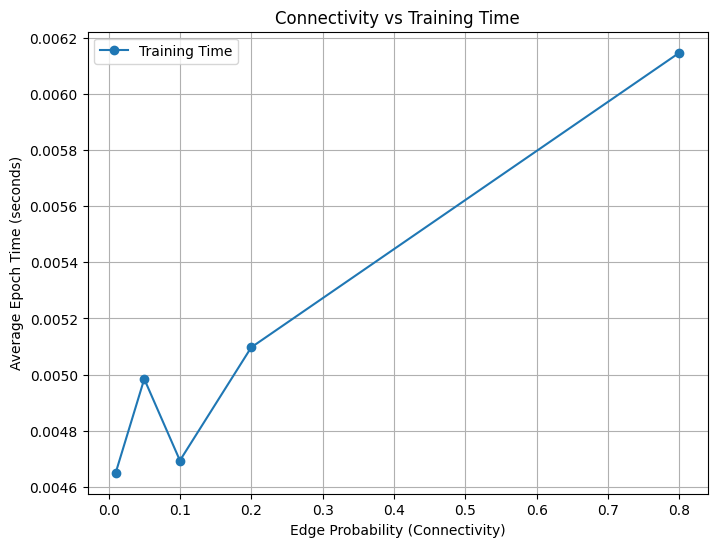

In [107]:
import matplotlib.pyplot as plt

# Extract edge probabilities and times from the results
edge_probs = [result["edge_prob"] for result in er_results]
epoch_time = [result["avg_epoch_time"] for result in er_results]

# Plot connectivity (edge probability) vs training time
plt.figure(figsize=(8, 6))
plt.plot(edge_probs, epoch_time, marker="o", linestyle="-", label="Training Time")
plt.title("Connectivity vs Training Time")
plt.xlabel("Edge Probability (Connectivity)")
plt.ylabel("Average Epoch Time (seconds)")
plt.grid(True)
plt.legend()
plt.show()


In [62]:
from torch_geometric.datasets import PPI

# Specify the root directory for the dataset
root = "/tmp/PPI"

# Load training, validation, and test datasets
train_dataset = PPI(root, split="train")
val_dataset = PPI(root, split="val")
test_dataset = PPI(root, split="test")

# Example: Inspect the first graph in the training set
data = train_dataset[0]
print(data)

Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])


In [63]:
from torch_geometric.loader import DataLoader

# Create data loaders for train, validation, and test splits
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

# Example: Iterate over a batch
for batch in train_loader:
    print(batch)
    print("Batch size:", batch.num_graphs)
    break

DataBatch(x=[5216, 50], edge_index=[2, 149738], y=[5216, 121], batch=[5216], ptr=[3])
Batch size: 2


In [64]:
import torch

def prune_edges(data, prune_prob):
    """
    Randomly deletes edges with a given probability.
    Args:
        data (Data): A PyTorch Geometric data object.
        prune_prob (float): Probability of deleting each edge.
    Returns:
        Data: Modified data object with pruned edges.
    """
    edge_index = data.edge_index
    num_edges = edge_index.size(1)

    # Create a mask to keep edges with (1 - prune_prob)
    mask = torch.rand(num_edges) > prune_prob
    pruned_edge_index = edge_index[:, mask]

    # Update the edge_index in the data object
    data.edge_index = pruned_edge_index
    return data


In [70]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, BCEWithLogitsLoss
from torch_geometric.nn import GCNConv  # Default GNN layer
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from sklearn.metrics import f1_score

class SkipMPNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(SkipMPNN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.skip_connections = torch.nn.ModuleList()

        # Input layer
        self.layers.append(GCNConv(in_channels, hidden_channels))  # Default GNN layer
        for _ in range(num_layers - 1):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
            self.skip_connections.append(Linear(hidden_channels, hidden_channels))

        # Output layer
        self.out = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, return_features=False):
        hidden = x
        for i, layer in enumerate(self.layers):
            updated = layer(hidden, edge_index)
            if i > 0:  # Apply skip connection
                updated = updated + self.skip_connections[i - 1](hidden)
            hidden = F.relu(updated)
        return self.out(hidden)

# 3. Initialize Model, Optimizer, and Loss Function
model = SkipMPNN(
    in_channels=train_dataset.num_node_features,
    hidden_channels=128,
    out_channels=train_dataset.num_classes,
    num_layers=3
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = BCEWithLogitsLoss()

In [66]:
model = SkipMPNN(
    in_channels=train_dataset.num_node_features,
    hidden_channels=128,
    out_channels=train_dataset.num_classes,
    num_layers=3
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = BCEWithLogitsLoss()

# 4. Training Loop
def train(loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [72]:
def extract_features(loader, model):
    """
    Extract node features (embeddings) from the model.
    Args:
        loader (DataLoader): DataLoader for the dataset.
        model (SkipMPNN): Trained GNN model.

    Returns:
        embeddings (Tensor): Extracted node embeddings.
        labels (Tensor): Corresponding node labels.
    """
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            # Forward pass with feature extraction
            features = model(data.x, data.edge_index, return_features=True)
            embeddings.append(features.cpu())
            labels.append(data.y.cpu())
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

# Example usage

In [78]:
# Early stopping parameters
f1_delta = 0.001  # Minimum increase in validation F1 to consider it improving
non_improving_epochs_limit = 5  # Stop if no improvement after this many epochs

prune_probs = [0, 0.1, 0.3, 0.5, 0.7]  # Different levels of sparsity

results = []

for prune_prob in prune_probs:
    print(f"Running with pruning probability: {prune_prob}")

    # Prune edges in the training and validation datasets
    pruned_train_dataset = [prune_edges(data.clone(), prune_prob) for data in train_dataset]
    pruned_val_dataset = [prune_edges(data.clone(), prune_prob) for data in val_dataset]

    # Create new DataLoaders for pruned datasets
    pruned_train_loader = DataLoader(pruned_train_dataset, batch_size=2, shuffle=True)
    pruned_val_loader = DataLoader(pruned_val_dataset, batch_size=2)

    # Reinitialize the model for each pruning level
    model = SkipMPNN(
        in_channels=train_dataset.num_node_features,
        hidden_channels=128,
        out_channels=train_dataset.num_classes,
        num_layers=3
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train and evaluate the model with early stopping
    best_val_f1 = 0  # Best validation F1-score seen so far
    non_improving_epochs = 0  # Counter for non-improving epochs
    epoch_times = []

    for epoch in range(100):
        start_time = time.time()

        train_loss = train(pruned_train_loader)
        val_f1 = evaluate(pruned_val_loader)
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Validation F1: {val_f1:.4f}, Time: {epoch_time:.2f}s")

        # Early stopping check based on validation F1
        if val_f1 - best_val_f1 > f1_delta:
            best_val_f1 = val_f1
            non_improving_epochs = 0
        else:
            non_improving_epochs += 1

        if non_improving_epochs >= non_improving_epochs_limit:
            print(f"Stopping early at epoch {epoch + 1} due to lack of improvement in validation F1.")
            break

    # Extract average epoch time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)

    # Extract embeddings for analysis
    train_embeddings, train_labels = extract_features(pruned_train_loader, model)
    val_embeddings, val_labels = extract_features(pruned_val_loader, model)

    # Save results for this pruning probability
    results.append({
        "prune_prob": prune_prob,
        "final_loss": train_loss,
        "best_val_f1": best_val_f1,
        "avg_epoch_time": avg_epoch_time,
        "epochs_trained": epoch + 1,  # Record number of epochs completed
        "extracted_features_train": train_embeddings,
        "extracted_labels_train": train_labels,
        "extracted_features_val": val_embeddings,
        "extracted_labels_val": val_labels,
    })

# Print final results
print("\nSummary of Results:")
for result in results:
    print(f"Prune Probability: {result['prune_prob']:.2f}, Final Loss: {result['final_loss']:.4f}, "
          f"Best Validation F1: {result['best_val_f1']:.4f}, Avg Epoch Time: {result['avg_epoch_time']:.2f}s, "
          f"Epochs Trained: {result['epochs_trained']}")



Running with pruning probability: 0
Epoch 1, Train Loss: 0.6094, Validation F1: 0.3952, Time: 1.50s
Epoch 2, Train Loss: 0.5559, Validation F1: 0.4010, Time: 1.55s
Epoch 3, Train Loss: 0.5411, Validation F1: 0.4124, Time: 1.58s
Epoch 4, Train Loss: 0.5298, Validation F1: 0.4510, Time: 1.67s
Epoch 5, Train Loss: 0.5176, Validation F1: 0.5404, Time: 1.74s
Epoch 6, Train Loss: 0.5104, Validation F1: 0.5010, Time: 1.62s
Epoch 7, Train Loss: 0.4993, Validation F1: 0.5302, Time: 1.65s
Epoch 8, Train Loss: 0.4907, Validation F1: 0.5264, Time: 1.57s
Epoch 9, Train Loss: 0.4898, Validation F1: 0.5765, Time: 1.56s
Epoch 10, Train Loss: 0.4839, Validation F1: 0.5284, Time: 1.51s
Epoch 11, Train Loss: 0.4711, Validation F1: 0.5704, Time: 1.57s
Epoch 12, Train Loss: 0.4642, Validation F1: 0.5718, Time: 1.88s
Epoch 13, Train Loss: 0.4591, Validation F1: 0.5903, Time: 1.62s
Epoch 14, Train Loss: 0.4549, Validation F1: 0.5704, Time: 1.62s
Epoch 15, Train Loss: 0.4462, Validation F1: 0.5926, Time: 1.56

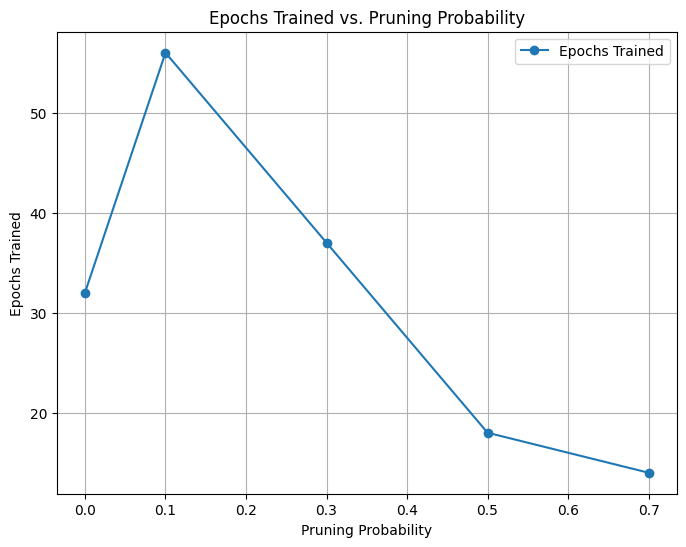

In [80]:
import matplotlib.pyplot as plt

# Assuming `results` contains your data
prune_probs = [result["prune_prob"] for result in results]
epochs_trained = [result["epochs_trained"] for result in results]

# Plot epochs trained vs. prune probability
plt.figure(figsize=(8, 6))
plt.plot(prune_probs, epochs_trained, marker="o", linestyle="-", label="Epochs Trained")
plt.title("Epochs Trained vs. Pruning Probability")
plt.xlabel("Pruning Probability")
plt.ylabel("Epochs Trained")
plt.grid(True)
plt.legend()
plt.show()


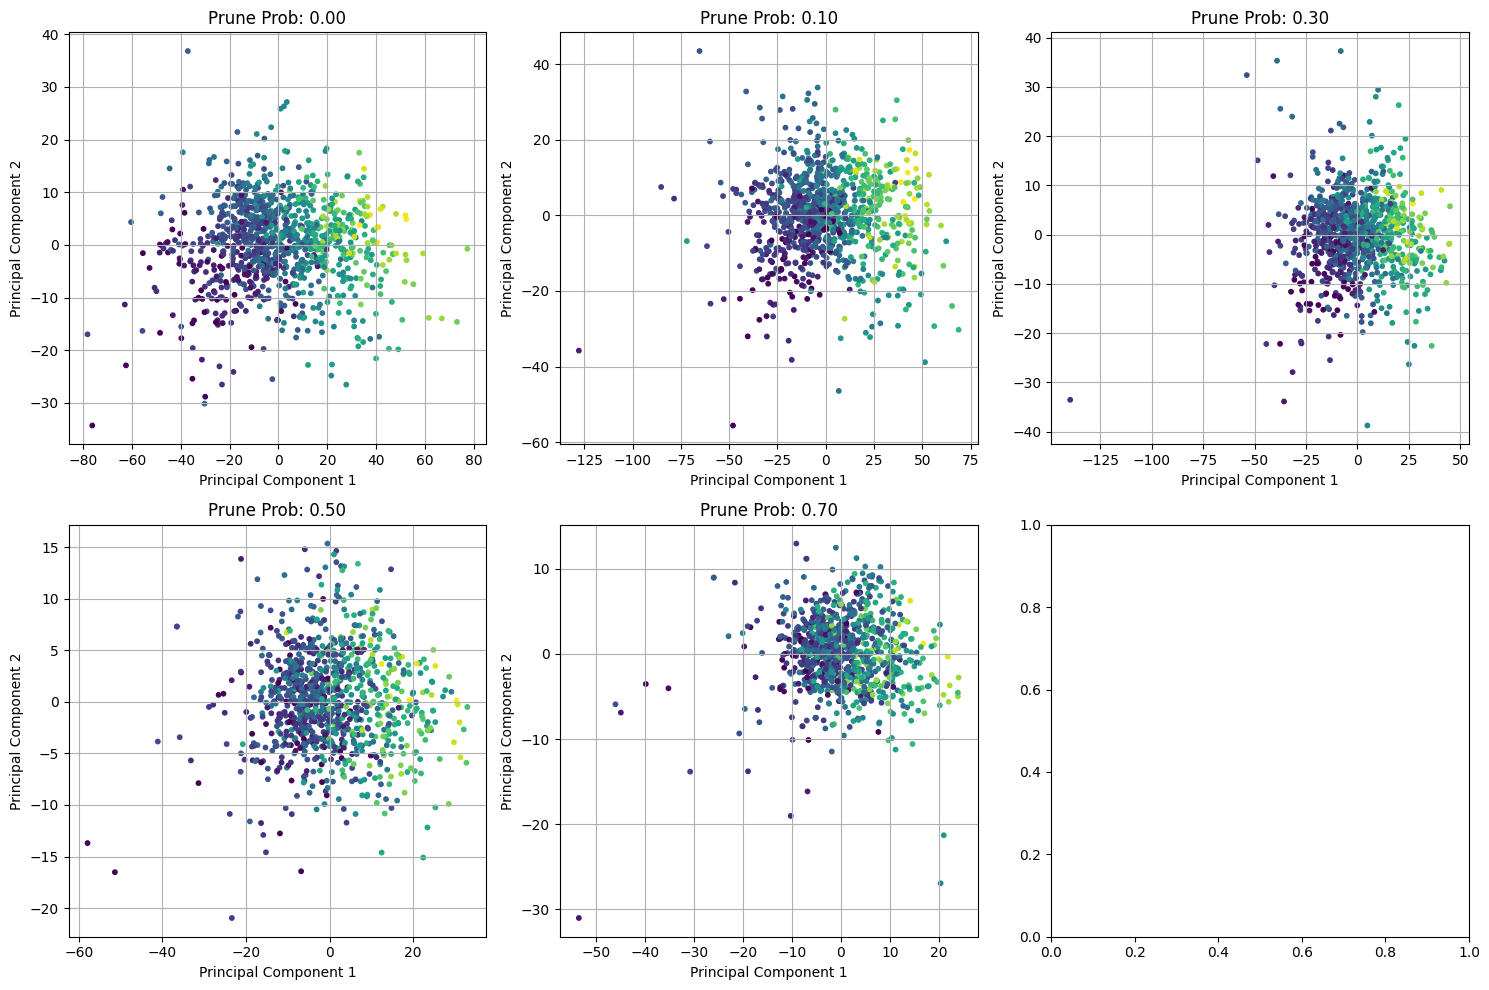

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from math import ceil

# Parameters for subgraph extraction
num_subgraph_nodes = 1000  # Number of nodes in the subgraph

# Calculate number of rows and columns for subplots
num_plots = len(results)
cols = 3  # Number of columns in the grid
rows = ceil(num_plots / cols)  # Number of rows based on number of results

# Create the figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i, result in enumerate(results):
    prune_prob = result["prune_prob"]
    embeddings = result["extracted_features_train"].numpy()
    labels = result["extracted_labels_train"].numpy()

    # Generate a random subset of nodes for the subgraph
    subgraph_nodes = torch.randperm(len(embeddings))[:num_subgraph_nodes]
    subgraph_nodes = subgraph_nodes.numpy()

    # Extract the subgraph embeddings and labels
    subgraph_embeddings = embeddings[subgraph_nodes]
    subgraph_labels = labels[subgraph_nodes]

    # Sum the labels to create a single value per node
    label_sums = subgraph_labels.sum(axis=1)  # Shape: [num_nodes]

    # Apply PCA to reduce subgraph embeddings to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(subgraph_embeddings)

    # Plot in the corresponding subplot
    scatter = axes[i].scatter(
        reduced_embeddings[:, 0],
        reduced_embeddings[:, 1],
        c=label_sums,
        cmap="viridis",  # Continuous color map
        s=10
    )
    axes[i].set_title(f"Prune Prob: {prune_prob:.2f}")
    axes[i].set_xlabel("Principal Component 1")
    axes[i].set_ylabel("Principal Component 2")
    axes[i].grid(True)


# Adjust layout
plt.tight_layout()
plt.show()
